<a href="https://colab.research.google.com/github/oailnivek/ML100-Days/blob/master/homework/Day_081_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten
from keras.optimizers import RMSprop
from keras.regularizers import l1, l2, l1_l2

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 52s 0us/step


In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train, flatten=False)
x_test = preproc_x(x_test, flatten=False)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

x_train.shape

(50000, 32, 32, 3)

In [9]:
def build_mlp(regularize):
    """
    Build your own model
    """
    
    if regularize is None:
         regularize = (lambda x: None, None)
            
    regularizer, scale = regularize
    
    # CNN

    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=x_train.shape[1:]))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizer(scale)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizer(scale)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizer(scale)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=regularizer(scale)))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    return model

def summary():
    model = build_mlp((l1, 1e-4))
    model.summary()
    
summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [0]:
## 超參數設定
"""
Set your hyper-parameters
"""
REGULARIZER = [l1, l2, l1_l2]
SCALE = [1e-2, 1e-4, 1e-8, 1e-12]

In [11]:
from itertools import product

results = {}
lr = 1e-4
batch_size = 128
epochs = 200

"""
Set your training loop
"""
cb = [None] + list(product(REGULARIZER, SCALE))

for regularize in cb:
    if regularize is None:
        name = 'none'
    else:
        name = '{}({})'.format(regularize[0].__name__, regularize[1])

    print(name)
    
    keras.backend.clear_session()
    model = build_mlp(regularize)
    optimizer = RMSprop(lr=lr, decay=1e-6)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    history = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, y_test), 
        shuffle=True,
        verbose=0
    )

    results[name] = history

none
l1(0.01)
l1(0.0001)
l1(1e-08)
l1(1e-12)
l2(0.01)
l2(0.0001)
l2(1e-08)
l2(1e-12)
l1_l2(0.01)
l1_l2(0.0001)
l1_l2(1e-08)
l1_l2(1e-12)


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
"""
plot the results
"""

def plot(results):
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    
    for name, history in results.items():
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        ax[0].plot(loss, linestyle='-', label=name)
        ax[0].plot(val_loss, linestyle='--', label=name)
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Loss')
        ax[0].legend()

    for name, history in results.items():
        acc = history.history['acc']
        val_acc = history.history['val_acc']

        ax[1].plot(acc, linestyle='-', label=name)
        ax[1].plot(val_acc, linestyle='--', label=name)
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Accuracy')
        ax[1].legend()

    plt.tight_layout()
    plt.show()

Without regularization


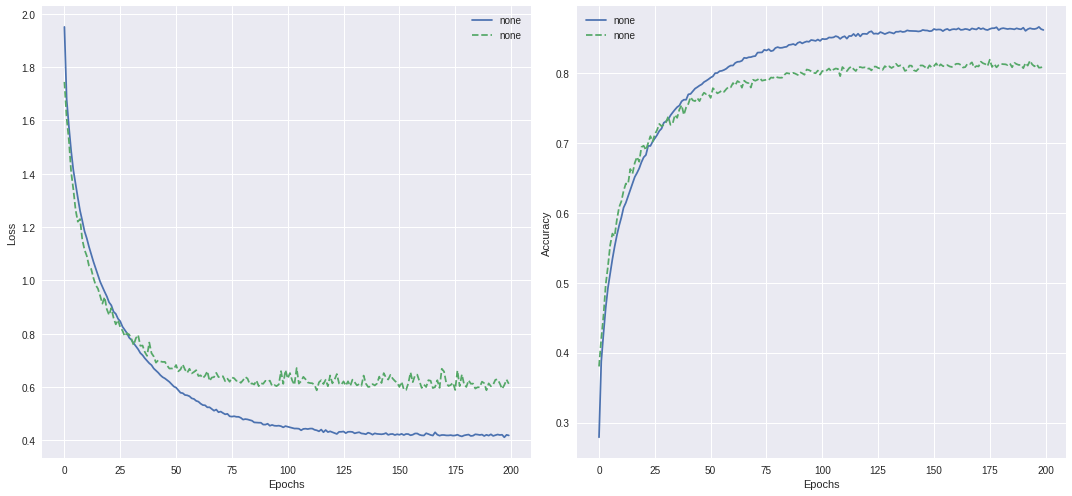

In [50]:
print('Without regularization')
plot({ k: v for k, v in results.items() if k.startswith('none') })

l1


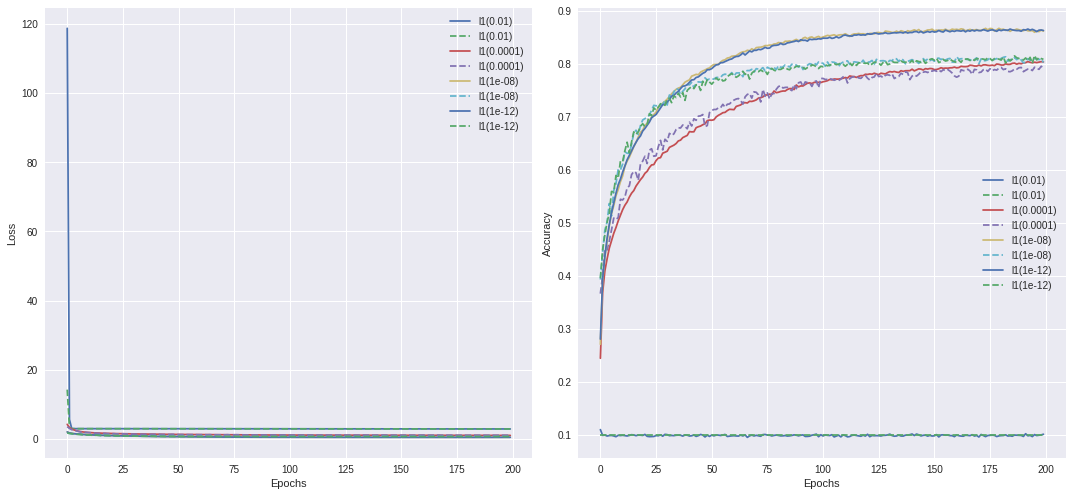

In [51]:
print('l1')
plot({ k: v for k, v in results.items() if k.startswith('l1(') })

l2


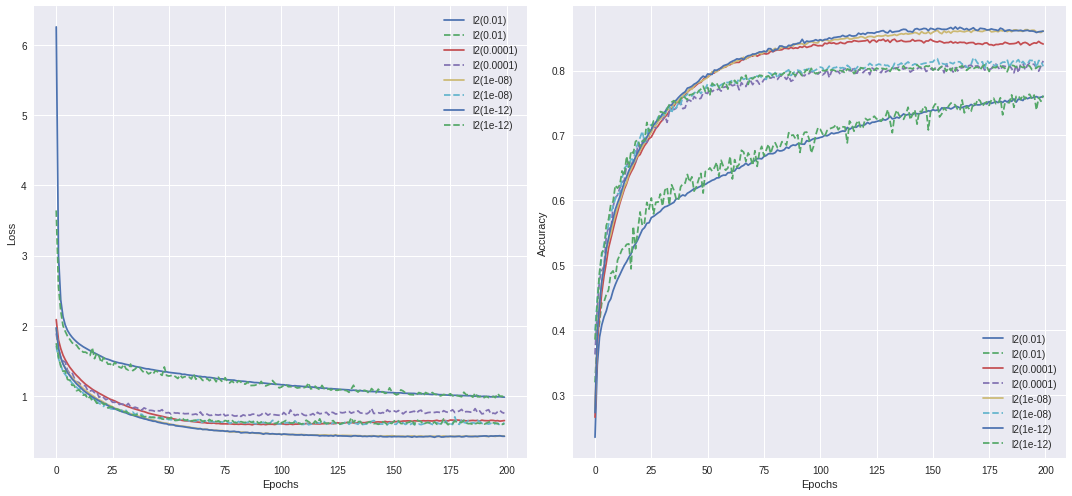

In [52]:
print('l2')
plot({ k: v for k, v in results.items() if k.startswith('l2(') })

l1_l2


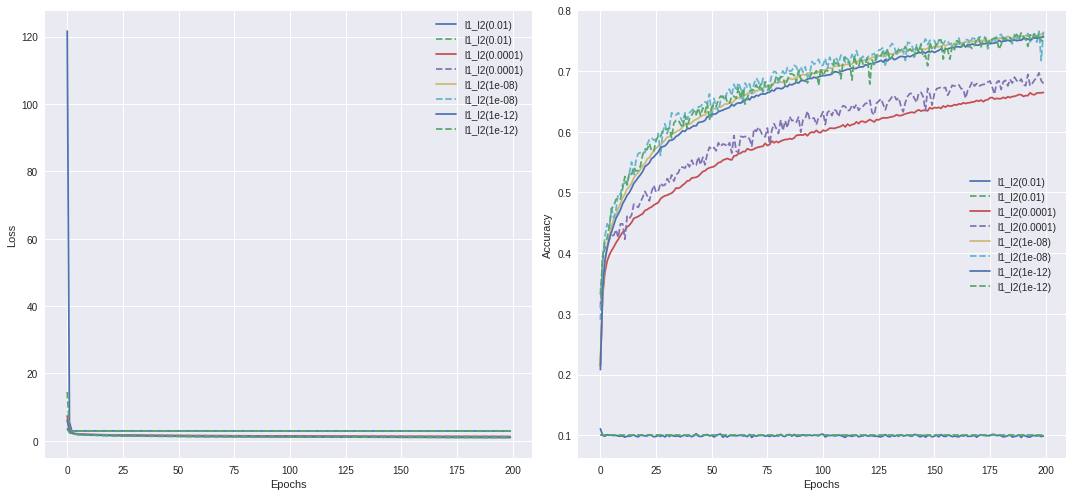

In [53]:
print('l1_l2')
plot({ k: v for k, v in results.items() if k.startswith('l1_l2(') })